<a href="https://colab.research.google.com/github/JenFaith/DS-Unit-2-Linear-Models/blob/master/Faith_LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

#Step 1: Wrangle Data

In [27]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [28]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv',
                 index_col='created',
                 parse_dates=['created'])
# assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [29]:
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
#Engineering column "interest_level" to be numerical

def my_function(name):
  if name == 'low':
    return 1
  if name == 'medium':
    return 2
  else:
    return 3

df['interest_rating'] = df['interest_level'].apply(my_function)

In [32]:
df['bed&bath']= df['bathrooms'] + df['bedrooms']

In [35]:
df['luxury_rating'] = df['high_speed_internet'] + df['dining_room'] + df['balcony'] + df['terrace']+ df['new_construction']+ df['elevator'] + df['hardwood_floors']+ df['doorman'] + df['dishwasher']+df['garden_patio']

In [39]:
df.head(10)

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,interest_rating,bed&bath,luxury_rating
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4.5,0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.0,2
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2.0,2
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.0,1
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.0,0
2016-04-19 04:24:47,2.0,4,,West 18th Street,40.7429,-74.0028,7995,350 West 18th Street,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6.0,0
2016-04-27 03:19:56,1.0,2,Stunning unit with a great location and lots o...,West 107th Street,40.8012,-73.9660,3600,210 West 107th Street,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.0,0
2016-04-13 06:01:42,2.0,1,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,40.7427,-73.9957,5645,155 West 21st Street,low,1,0,1,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,3.0,5
2016-04-20 02:36:35,1.0,1,<p><a website_redacted,Hamilton Terrace,40.8234,-73.9457,1725,63 Hamilton Terrace,medium,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2.0,1


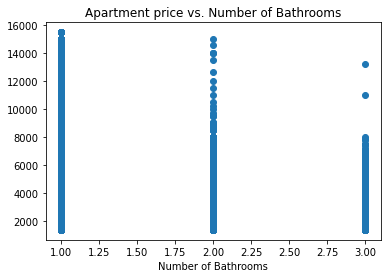

In [41]:
import matplotlib.pyplot as plt

plt.scatter(df['interest_rating'], df['price'])
plt.xlabel('Price of Apartment')
plt.xlabel('Number of Bathrooms')
plt.title('Apartment price vs. Number of Bathrooms');

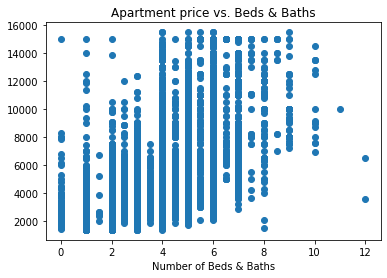

In [42]:
import matplotlib.pyplot as plt

plt.scatter(df['bed&bath'], df['price'])
plt.xlabel('Price of Apartment')
plt.xlabel('Number of Beds & Baths')
plt.title('Apartment price vs. Beds & Baths');

#Step 2: Split Data

In [92]:
#Target Vector- 1 dimensional
y = df['price']


#'high_speed_internet',	'balcony',	'swimming_pool',	'new_construction',	'terrace',	'exclusive',	'loft',	'garden_patio',	'wheelchair_access',	'common_outdoor_space'

#Feature Matrix - 2 dimensional
X = df[['bed&bath', 'interest_rating','luxury_rating', 'elevator','latitude', 'longitude', 'cats_allowed',	'hardwood_floors',	'dogs_allowed',	'doorman','dishwasher', 'no_fee',	'laundry_in_building',	'fitness_center',	'pre-war',	'laundry_in_unit',	'roof_deck',	'outdoor_space',	'dining_room','high_speed_internet',	'balcony',	'swimming_pool',	'new_construction',	'terrace',	'exclusive',	'loft',	'garden_patio',	'wheelchair_access',	'common_outdoor_space']]

In [93]:
##INSTRUCTIONS: Use data from April & May 2016 to train. Use data from June 2016 to test.

#Creating mask to only pull dates before June 1st
mask = df.index < '2016-06-01 00:00:00'

X_train, y_train = X.loc[mask], y.loc[mask]
#Why did we use the .loc here?

X_test, y_test = X.loc[~mask], y.loc[~mask]

In [94]:
#Checking masking work
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31844, 29), (31844,), (16973, 29), (16973,))

#Step 3: Establish Baseline

In [95]:
from sklearn.metrics import mean_absolute_error

mean = y_train.mean()
y_pred = [mean] * len(y_train)
baseline_MAE = mean_absolute_error(y_train, y_pred)
print(baseline_MAE)

1201.8811133682555


#Step 4: Build Model

In [96]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train);

#Step 5: Check Metrics

##Finding Mean Absolute Error

In [97]:
training_MAE = mean_absolute_error(y_train, model.predict(X_train))
testing_MAE = mean_absolute_error(y_test, model.predict(X_test))

print('The training MAE is', training_MAE)
print('The testing MAE is', testing_MAE)

The training MAE is 717.9194618344898
The testing MAE is 723.859365434009


##Finding R^2

In [98]:
from sklearn.metrics import r2_score
train_R_SQ = r2_score(y_train, model.predict(X_train))
test_R_SQ = r2_score(y_test, model.predict(X_test))

print('Training R^2:', train_R_SQ)
print('Test R^2:', test_R_SQ)

Training R^2: 0.5935593716218225
Test R^2: 0.6004145079751146


In [99]:
#Ask during office hours


R_sq_train = model.score(X_train, y_train)
R_sq_test = model.score(X_test, y_test)

print('The training R^2 is', R_sq_train)
print('The testing R^2 is', R_sq_test)


#look up documentation for model.

The training R^2 is 0.5935593716218225
The testing R^2 is 0.6004145079751146


##Model Coefficients and Intercepts

In [102]:
COEF = [model.coef_]
INTERCEPTS = [model.intercept_]